Purpose of this notebook is to setup a simple VAE that can learn poses of cubes.

@yvan june 9 2018

Setup

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.utils import data
from torch.autograd import Variable
from torch import optim
from torchvision.datasets import ImageFolder, MNIST
from torchvision.utils import make_grid
from torchvision.transforms import transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# constants
NEPOCHS = 25
BATCH_SIZE = 64
SEED = 1337
IMG_DIM = 64
ncpus = !nproc
NCPUS = int(ncpus[0])
EMBED_DIM = 25
LR = 1e-3
IMG_PATH = '/home/yvan/data_load/imgs_jpg_clpr_128/'

In [3]:
torch.cuda.is_available(), torch.__version__, torch.cuda.device_count(), torch.cuda.device(0)

(True, '0.4.0', 2, <torch.cuda.device at 0x7f5278137fd0>)

In [4]:
t = transforms.Compose([transforms.ToTensor()])
cube_dataset = ImageFolder(IMG_PATH, transform=t)
cube_loader = data.DataLoader(dataset=cube_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NCPUS)

Create a convlutional VAE model.

In [5]:
#### thanks to https://github.com/wanglouis49/pytorch-autoencoders/blob/master/conv_vae.py
class Vae(nn.Module):
    def __init__(self):
        super(Vae,self).__init__()
        # encoder layers
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(3, 64, kernel_size=2, stride=2, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*16*16, 128)
        
        # our emdedded latent space
        self.embed_mu = nn.Linear(128, EMBED_DIM)
        self.embed_logvar = nn.Linear(128, EMBED_DIM)
        
        # decoder layers
        self.fc2 = nn.Linear(EMBED_DIM, 128)
        self.bnfc2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64*16*16)
        self.bnfc3 = nn.BatchNorm1d(64*16*16)
        
        # more decoder layers
        self.deconv1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn7 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn8 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0)
        self.bn9 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0)
        self.bn10 = nn.BatchNorm2d(64)
        self.conv_end = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        
    def encode(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = x.view(x.size(0), -1) # flatten
        x = F.relu(self.fc1(x))
        return self.embed_mu(x), self.embed_logvar(x)
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp()
            epsilon = torch.cuda.FloatTensor(std.size()).normal_()
            epsilon = Variable(epsilon)
            return epsilon.mul(std).add(mu)
        else:
            return mu
    
    def decode(self, x):
        x = F.relu(self.bnfc2(self.fc2(x)))
        x = F.relu(self.bnfc3(self.fc3(x)))
        x = x.view(x.size(0), 64, 16, 16)
        x = F.relu(self.bn7(self.deconv1(x)))
        x = F.relu(self.bn8(self.deconv2(x)))
        x = F.relu(self.bn9(self.deconv3(x)))
        x = F.relu(self.bn10(self.deconv4(x)))
        x = F.sigmoid(self.conv_end(x))
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
def loss_func(reconstructed, original, mu, logvar):
    bce = F.binary_cross_entropy(reconstructed.view(-1, 3*64*64),
                                             original.view(-1, 3*64*64),
                                             size_average=False)
    kld = -torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

def sample_vae(model):
    model.eval()
    sample = torch.randn(64, EMBED_DIM).cuda()
    sample = model.decode(sample).cpu()
    
    # make a grid and view it
    firstimg = sample.view(64, 3, 64, 64)
    grid = make_grid(firstimg)
    grid = transforms.Compose([transforms.ToPILImage()])(grid)
    plt.figure()
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

def save_static_vae(static_embedding, model, name):
    model.eval()
    sample = model.decode(static_embedding).cpu()
    firstimg = sample.view(64, 3, 64, 64)
    # make a grid and save it
    grid = make_grid(firstimg)
    grid = transforms.Compose([transforms.ToPILImage()])(grid)
    grid.save(name)

epoch1: total_loss - 301135.18620689656
epoch2: total_loss - 231563.0604525862
epoch3: total_loss - 209388.86357758622
epoch4: total_loss - 204593.77931034483
epoch5: total_loss - 202108.56002155173


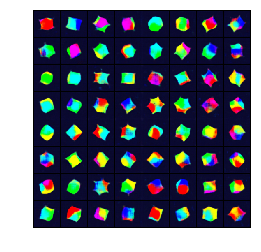

epoch6: total_loss - 200418.36961206896
epoch7: total_loss - 199029.20237068966
epoch8: total_loss - 198687.653125
epoch9: total_loss - 197896.91443965517
epoch10: total_loss - 197114.33049568965


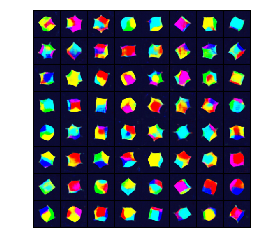

epoch11: total_loss - 196357.01023706896
epoch12: total_loss - 195699.24073275863
epoch13: total_loss - 195670.68674568966
epoch14: total_loss - 195460.2213362069
epoch15: total_loss - 194717.79547413794


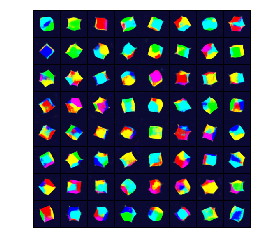

epoch16: total_loss - 194286.21573275863
epoch17: total_loss - 194236.16206896552
epoch18: total_loss - 193820.06670258622
epoch19: total_loss - 193622.46433189654
epoch20: total_loss - 193569.77112068966


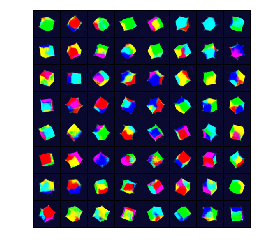

epoch21: total_loss - 192994.3869612069
epoch22: total_loss - 192744.1808189655
epoch23: total_loss - 192667.18114224137
epoch24: total_loss - 192589.23394396552
epoch25: total_loss - 192148.1228448276


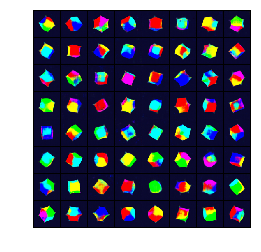

In [6]:
model = Vae()
if torch.cuda.is_available():
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=LR)
static_embedding = torch.randn(64, EMBED_DIM).cuda()

for epoch in range(NEPOCHS):
    model.train()
    epoch_losses = []
    for i, batch in enumerate(cube_loader):
        # get and flatten img, move to gpu
        img, _ = batch
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        # run our vae
        reconstructed_batch, mu, logvar = model(img)
        loss = loss_func(reconstructed_batch, img, mu, logvar)
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    save_static_vae(static_embedding, model, f'snapshot_{epoch}_grid.jpg')
    print(f'epoch{epoch+1}: total_loss - {np.mean(epoch_losses)}')
    if not ((epoch+1) % 5):
        sample_vae(model)

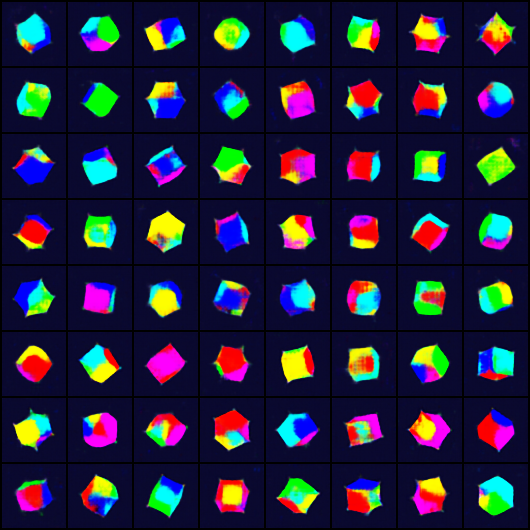

In [7]:
model.eval()
sample = torch.randn(64, EMBED_DIM).cuda()
# sample = torch.stack([torch.arange(-2,2,4/EMBED_DIM) for i in range(0, 64)]).cuda()
sample = model.decode(sample).cpu()

firstimg = sample.view(64, 3, 64, 64)
grid = make_grid(firstimg)
grid = transforms.Compose([transforms.ToPILImage()])(grid)
grid

In [8]:
grid.save('wow5.jpg')